In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [ ]:
torch.manual_seed(121212)
np.random.seed(121212)
#torch.manual_seed(334421)
#np.random.seed(334421)

### Data Generating

In [ ]:
n_informative_features = 2
n_redundant_features = 3
n_features = n_informative_features + n_redundant_features
n_classes = 2
n_samples_per_class = 100

In [ ]:
from sklearn.datasets import make_classification
features_orig_1, labels_orig_1 = make_classification(
    n_samples=n_samples_per_class*n_classes//2,
    n_informative=n_informative_features,
    n_redundant=n_redundant_features,
    n_features=n_features,
    flip_y=0.,
    shuffle=False,
    shift=-0.3,
    random_state=121212
)

In [ ]:
from sklearn.datasets import make_classification
features_orig_2, labels_orig_2 = make_classification(
    n_samples=n_samples_per_class*n_classes//2,
    n_informative=n_informative_features,
    n_redundant=n_redundant_features,
    n_features=n_features,
    flip_y=0.,
    shuffle=False,
    shift=+0.3,
    random_state=121214
)

In [ ]:
features_orig = np.concatenate((features_orig_1, features_orig_2))
labels_orig = np.concatenate((labels_orig_1, labels_orig_2))

In [ ]:
plt.scatter(
    features_orig[:,0], features_orig[:,1], c=labels_orig
)

## Idea MARCO

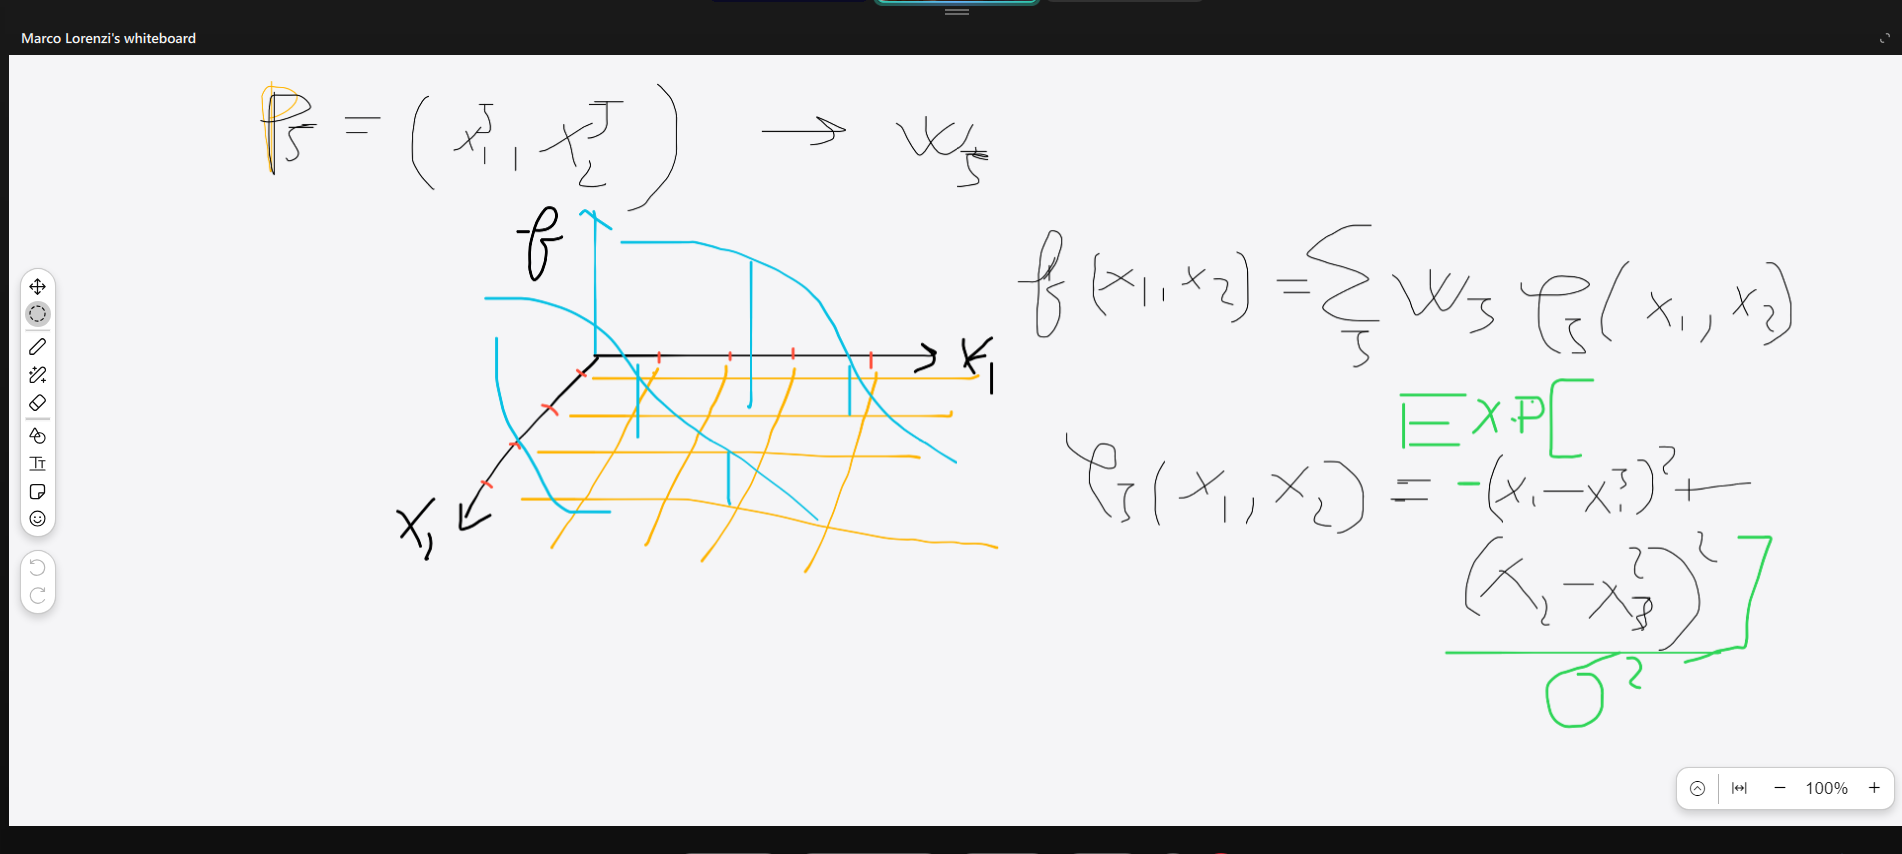

In [ ]:
n_grid_points_per_latent_feature = 6  # number of grid points on each coordinate 
latent_feature_support = [features_orig.min()*0.5, features_orig.max()*2.]  # the min and max value of latent features

# Generate random weights for each sample and feature
grid_points_one_coord = np.linspace(start=latent_feature_support[0],
                                    stop=latent_feature_support[1], 
                                    num=n_grid_points_per_latent_feature)
grid_points = np.array(np.meshgrid(*[grid_points_one_coord]*n_features)).T.reshape(-1,n_features)

In [ ]:
def neg_sq_exp(x, c, sigma):
    return np.exp(-(x-c)**2/(2.*sigma**2))

In [ ]:
def interpolator(x,c,sigma,w):
    return np.sum(
        [w[i] * neg_sq_exp(x,c[i],sigma) for i in range(len(c))]
        ,0)

### Plot one example of warped features

In [ ]:
weights = np.random.uniform(low=0.01, high=1., size=grid_points.shape )
weights = weights/weights.sum(axis=0)

In [ ]:
warped = interpolator(features_orig, grid_points, sigma=1.5, w=weights)

In [ ]:
plt.scatter(
    warped[:,0], warped[:,1], c=labels_orig
)

In [ ]:
def warp1(x):
    W = np.random.uniform(low=0.1, high=1., size=grid_points.shape )
    W = W/W.sum()
    sigma = 10.
    return interpolator(x, grid_points, sigma=sigma, w=W)

In [ ]:
def warp2(x):
    W = np.random.uniform(low=0.1, high=1., size=grid_points.shape )
    W = W/W.sum()
    sigma = 0.7
    return interpolator(x, grid_points, sigma=sigma, w=W)


### Features

In [ ]:
warped_features_1 = warp1(features_orig)
warped_features_2 = warp2(features_orig)

In [ ]:
warped_features_2.shape

### View dataset per client 1

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

# Scatter plot for the first subplot
scatter1 = ax[0].scatter(warped_features_1[:,0], warped_features_1[:,1], c=labels_orig)
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

# Scatter plot for the second subplot
scatter2 = ax[1].scatter(warped_features_1[:,0], warped_features_1[:,2], c=labels_orig)
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 3')

# Scatter plot for the third subplot
scatter3 = ax[2].scatter(warped_features_1[:,1], warped_features_1[:,2], c=labels_orig)
ax[2].set_xlabel('Feature 2')
ax[2].set_ylabel('Feature 3')

# Show the plot
plt.tight_layout()
plt.show()

### View dataset per client 2

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

# Scatter plot for the first subplot
scatter1 = ax[0].scatter(warped_features_2[:,0], warped_features_2[:,1], c=labels_orig)
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

# Scatter plot for the second subplot
scatter2 = ax[1].scatter(warped_features_2[:,0], warped_features_2[:,2], c=labels_orig)
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 3')

# Scatter plot for the third subplot
scatter3 = ax[2].scatter(warped_features_2[:,1], warped_features_2[:,2], c=labels_orig)
ax[2].set_xlabel('Feature 2')
ax[2].set_ylabel('Feature 3')

# Show the plot
plt.tight_layout()
plt.show()

### Clients

In [ ]:
class Client1(nn.Module):
    def __init__(self):
        super(Client1, self).__init__()

        self.encoder_model = nn.Sequential(nn.Linear(5, 20, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(20, 10, dtype=torch.float64),
                                           nn.ReLU()
                                    )

        self.decoder_model = nn.Sequential(nn.Linear(10, 8, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(8, 5, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(5, 2, dtype=torch.float64),
                                           nn.Softmax(dim=1))
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.1)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, inputs):
        outputs_encoder = self.encoder_model(inputs)
        outputs_class = self.decoder_model(outputs_encoder)
        latent_parameters = list(self.decoder_model.parameters())
        return outputs_class, latent_parameters


    def update(self, latent_parameters):
        # Get the parameters of the latent model
        latent_params = self.decoder_model.parameters()
    
        # Iterate over the parameters and update them with new values
        for param, new_value in zip(latent_params, latent_parameters):
            param.data.copy_(new_value)
    
    def train_step(self, inputs, labels):
        
        #Forward pass
        logits, latent_parameters = self.forward(inputs)

        #Compute the loss
        labels = labels.long()
        loss = self.loss_function(logits, labels)

        #Zero the gradients
        self.optimizer.zero_grad()

        #Backward pass
        loss.backward()

        #updare the parameters
        self.optimizer.step()

        return loss.item(), latent_parameters

In [ ]:
class Client2(nn.Module):
    def __init__(self):
        super(Client2, self).__init__()

        self.encoder_model = nn.Sequential(nn.Linear(5, 20, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(20, 10, dtype=torch.float64),
                                           nn.ReLU()
                                    )

 
        self.decoder_model = nn.Sequential(nn.Linear(10, 8, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(8, 5, dtype=torch.float64),
                                           nn.ReLU(),
                                           nn.Linear(5, 2, dtype=torch.float64),
                                           nn.Softmax(dim=1))
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.1)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, inputs):
        outputs_encoder = self.encoder_model(inputs)
        outputs_class = self.decoder_model(outputs_encoder)
        latent_parameters = list(self.decoder_model.parameters())
        return outputs_class, latent_parameters


    def update(self, latent_parameters):
        # Get the parameters of the latent model
        latent_params = self.decoder_model.parameters()
    
        # Iterate over the parameters and update them with new values
        for param, new_value in zip(latent_params, latent_parameters):
            param.data.copy_(new_value)
    
    def train_step(self, inputs, labels):
        
        #Forward pass
        logits, latent_parameters = self.forward(inputs)

        #Compute the loss
        labels = labels.long()
        loss = self.loss_function(logits, labels)

        #Zero the gradients
        self.optimizer.zero_grad()

        #Backward pass
        loss.backward()

        #updare the parameters
        self.optimizer.step()

        return loss.item(), latent_parameters

### Praparing the data

In [ ]:
X_train_C1, X_test_C1, y_train_C1, y_test_C1 = train_test_split(torch.tensor(warped_features_1), torch.tensor(labels_orig), test_size=0.2, random_state=42)
X_train_C2, X_test_C2, y_train_C2, y_test_C2 = train_test_split(torch.tensor(warped_features_2), torch.tensor(labels_orig), test_size=0.2, random_state=42)

In [ ]:
X_train_all_C1 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_train_C1)), torch.tensor(np.hstack(y_train_C1)))
X_test_all_C1 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_test_C1)), torch.tensor(np.hstack(y_test_C1)))

In [ ]:
X_train_all_C2 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_train_C2)), torch.tensor(np.hstack(y_train_C2)))
X_test_all_C2 = torch.utils.data.TensorDataset(torch.tensor(np.vstack(X_test_C2)), torch.tensor(np.hstack(y_test_C2)))

In [ ]:
trainloader_C1= torch.utils.data.DataLoader(X_train_all_C1, batch_size=64, shuffle=True, num_workers=2)
testloader_C1 = torch.utils.data.DataLoader(X_test_all_C1, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
trainloader_C2 = torch.utils.data.DataLoader(X_train_all_C2, batch_size=64, shuffle=True, num_workers=2)
testloader_C2 = torch.utils.data.DataLoader(X_test_all_C2, batch_size=64, shuffle=False, num_workers=2)

## Training

In [ ]:
client1 = Client1()
client2 = Client2()


num_epochs = 200
latent_parameters = []
losses_1 = []
losses_2 = []


#training loop
for epoch in range(num_epochs):
    
    client1.train()
    client2.train()
    epoch_loss_1 = 0.0
    epoch_loss_2 = 0.0
    
    for  i, ((x_c1, y_c1), (x_c2, y_c2)) in enumerate(zip(trainloader_C1, trainloader_C2)): 
        x_c1 = torch.tensor(x_c1)
        y_c1 = torch.tensor(y_c1, dtype=torch.long)
        x_c2 = torch.tensor(x_c2)
        y_c2 = torch.tensor(y_c2, dtype=torch.long)
        loss_1, latent_parameters_1 = client1.train_step(x_c1, y_c1)
        loss_2, latent_parameters_2 = client2.train_step(x_c2, y_c2)
        
        epoch_loss_1 += loss_1  # Accumulate losses
        epoch_loss_2 += loss_2
        
    epoch_loss_1 /= len(trainloader_C1)  # Average losses
    epoch_loss_2 /= len(trainloader_C2)
    
    losses_1.append(epoch_loss_1)  # Append to the list of losses
    losses_2.append(epoch_loss_2)
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_1:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_2:.4f}")
    if ((epoch+1) % 2 == 0):
        print(epoch+1)
        latent_parameters =[(x + y) / 2 for x, y in zip(latent_parameters_1, latent_parameters_2)]
        client1.update(latent_parameters)
        client2.update(latent_parameters)
    
    latent_parameters = []



In [ ]:
# Plotting the losses
plt.plot(losses_1, label='Client 1 Loss')
plt.plot(losses_2, label='Client 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

In [ ]:
total_accuracy_1 = 0.0
total_samples_1 = 0
total_accuracy_2 = 0.0
total_samples_2 = 0

for i, ((x_c1, y_c1), (x_c2, y_c2)) in enumerate(zip(testloader_C1, testloader_C2)):
    logits_1, _ = client1.forward(x_c1)
    logits_2, _ = client2.forward(x_c2)
        

    _, predictions_1 = torch.max(logits_1, 1)
    _, predictions_2 = torch.max(logits_2, 1)
        
    acc_1 = torch.mean((predictions_1 == y_c1).float())
    acc_2 = torch.mean((predictions_2 == y_c2).float())
    
    total_accuracy_1 += acc_1.item() * x_c1.size(0)
    total_samples_1 += x_c1.size(0)
    total_accuracy_2 += acc_2.item() * x_c2.size(0)
    total_samples_2 += x_c2.size(0)

final_accuracy_1 = total_accuracy_1 / total_samples_1
final_accuracy_2 = total_accuracy_2 / total_samples_2
print(f"Accuracy on test set: {final_accuracy_1 * 100:.2f}%")
print(f"Accuracy on test set: {final_accuracy_2 * 100:.2f}%")